<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** 
 - Luis Felipe Gómez Estrada   
 - Eduardo Loza de la Torre  
**Fecha:** 22 de febrero del 2021.

**Expediente** : IF722749. 
**Expediente** :   
**Profesor:** Oscar David Jaramillo Zuluaga.

# Tarea 10: Clase 23


# Tarea

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:

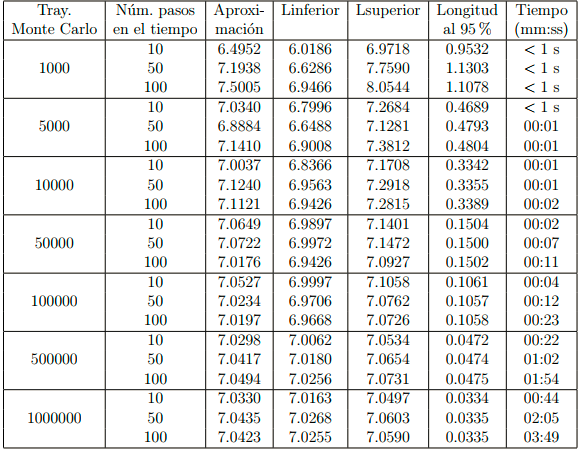

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

## Luis Felipe Gómez Estrada

### Opción Call

In [107]:
import pandas as pd
import numpy as np
import scipy.stats as st
from time import time

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)
pd.set_option('display.max_rows', None)

In [108]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

#### Utilizando Sumas de Riemann

In [109]:
def Riemann_approach(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                      flag=True):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t_i = time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos la opción según la formula obtenida para Sumas de Riemann
    if flag: # es call
        opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    else: 
        opt = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = opt.sem().Prima
    mean_est = opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_f = time()
    t_e = t_f-t_i
    return opt.iloc[-1].Prima,i1[0],i1[1],t_e

In [110]:
NbTraj = [1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000]
NbStep = [10, 50, 100]

S0 = 100     # Precio inicial
r = 0.10     # Tasa libre de riesgo 
sigma = 0.2  # volatilidad
K = 100      # Strike price
T = 1        # Tiempo de cierre - años

Riem_call = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T, True),NbStep)), NbTraj))

In [111]:
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = Riem_call
df

,NbStep = 10,NbStep = 50,NbStep = 100
Nbtray = 1000,"(6.508166852122, 5.215277126338059, 7.80105657...","(6.782268193514915, 6.274353962192572, 7.29018...","(6.955547650314502, 6.592219820979192, 7.31887..."
Nbtray = 5000,"(6.395278442437467, 5.132029698586117, 7.65852...","(6.798965940917584, 6.295769829426416, 7.30216...","(6.932161941410472, 6.577179607449662, 7.28714..."
Nbtray = 10000,"(6.519298548648008, 5.222107365562768, 7.81648...","(6.82338850538587, 6.3163286851607525, 7.33044...","(7.02279113898958, 6.660646272364677, 7.384936..."
Nbtray = 50000,"(6.418024647877493, 5.1463782405641005, 7.6896...","(6.932900379396401, 6.414147468121616, 7.45165...","(6.878852548577613, 6.525434522941368, 7.23227..."
Nbtray = 100000,"(6.417160488464909, 5.143338630433865, 7.69098...","(6.8973809676147955, 6.383290598852336, 7.4114...","(6.951934222513544, 6.594343082811541, 7.30952..."
Nbtray = 500000,"(6.422011841247139, 5.148582825087377, 7.69544...","(6.900313688838238, 6.385321480325927, 7.41530...","(6.976334244282235, 6.616797901755762, 7.33587..."
Nbtray = 1000000,"(6.4132312281625605, 5.142294303996965, 7.6841...","(6.913854463941348, 6.397494012822472, 7.43021...","(6.9804248882734585, 6.620611111560025, 7.3402..."


In [112]:
lvl = len(NbStep)
div = [int(i/lvl) for i in range(len(NbTraj)*lvl)]
mod = [int(i%lvl) for i in range(len(NbTraj)*lvl)]
indx = pd.MultiIndex(levels=[NbTraj,NbStep], codes=[div, mod])

riem_call_arr = np.array([Riem_call[div[i]][mod[i]] for i in range(len(div))])

aprox = np.array([i[0] for i in riem_call_arr])

Linf = np.array([i[1] for i in riem_call_arr])

Lsup = np.array([i[2] for i in riem_call_arr])

tiempos = np.array([i[3] for i in riem_call_arr])

Ldiff = np.array(Lsup-Linf)

tabla_Riem_call = pd.DataFrame(index=indx,columns=['Aproximacion','L. Inf','L. Sup','Long. 95%','Tiempo (segs)'])
tabla_Riem_call.index.names = (['Tray Monte Carlo','Núm pasos en el tiempo'])
tabla_Riem_call['Aproximacion'] = aprox
tabla_Riem_call['L. Inf'] = Linf
tabla_Riem_call['L. Sup'] = Lsup
tabla_Riem_call['Long. 95%'] = Ldiff
tabla_Riem_call['Tiempo (segs)'] = np.round(tiempos,2)
tabla_Riem_call

Aproximacion  L. Inf  L. Sup  \
Tray Monte Carlo Núm pasos en el tiempo                                 
1000             10                             6.508   5.215   7.801   
                 50                             6.782   6.274   7.290   
                 100                            6.956   6.592   7.319   
5000             10                             6.395   5.132   7.659   
                 50                             6.799   6.296   7.302   
                 100                            6.932   6.577   7.287   
10000            10                             6.519   5.222   7.816   
                 50                             6.823   6.316   7.330   
                 100                            7.023   6.661   7.385   
50000            10                             6.418   5.146   7.690   
                 50                             6.933   6.414   7.452   
                 100                            6.879   6.525   7.232   
100000           10                             6.417   5.143   7.691   
                 50                             6.897   6.383   7.411   
                 100                            6.952   6.594   7.310   
500000           10                             6.422   5.149   7.695   
                 50                             6.900   6.385   7.415   
                 100                            6.976   6.617   7.336   
1000000          10                             6.413   5.142   7.684   
                 50                             6.914   6.397   7.430   
                 100                            6.980   6.621   7.340   

                                         Long. 95%  Tiempo (segs)  
Tray Monte Carlo Núm pasos en el tiempo                            
1000             10                          2.586           0.05  
                 50                          1.016           0.05  
                 100                         0.727           0.05  
5000             10                          2.526           0.17  
                 50                          1.006           0.20  
                 100                         0.710           0.23  
10000            10                          2.594           0.35  
                 50                          1.014           0.45  
                 100                         0.724           0.45  
50000            10                          2.543           2.12  
                 50                          1.038           2.39  
                 100                         0.707           2.51  
100000           10                          2.548           4.03  
                 50                          1.028           4.96  
                 100                         0.715           5.81  
500000           10                          2.547          21.32  
                 50                          1.030          22.93  
                 100                         0.719          26.59  
1000000          10                          2.542          47.58  
                 50                          1.033          50.67  
                 100                         0.720          70.42

In [113]:
def Trapecio(K:'Strike price', 
             r:'Tasa libre de riesgo',
             S0:'Precio inicial', 
             NbTraj:'Número trayectorias',
             NbStep:'Cantidad de pasos a simular', 
             sigma:'Volatilidad',
             T:'Tiempo de cierre del contrato en años',
             flag=True):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t_i = time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)

    h = T/NbStep
    Average_t = np.cumsum(np.multiply(prices,(2+r*h+np.random.randn(NbStep,NbTraj)*sigma)))*h/(2*T)
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos la opción según la formula obtenida para método de trapecios
    if flag:
        opt = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    else:
        opt = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = opt.sem().Prima
    mean_est = opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_f = time()
    t_e = t_f-t_i
    return opt.iloc[-1].Prima,i1[0],i1[1],t_e

In [114]:
Trap_call = list(map(lambda N_tra:list(map(lambda N_ste:Trapecio(K,r,S0,N_tra,N_ste,sigma,T,True),NbStep)), NbTraj))

In [115]:
trap_call_arr = np.array([Trap_call[div[i]][mod[i]] for i in range(len(div))])

aprox_trap_call = np.array([i[0] for i in trap_call_arr])

Linf_trap_call = np.array([i[1] for i in trap_call_arr])

Lsup_trap_call = np.array([i[2] for i in trap_call_arr])

tiempos_trap_call = np.array([i[3] for i in trap_call_arr])

Ldiff_trap_call = np.array(Lsup_trap_call-Linf_trap_call)

tabla_trap_call = pd.DataFrame(index=indx,columns=['Aproximacion','L. Inf','L. Sup','Long. 95%','Tiempo (segs)'])
tabla_trap_call.index.names = (['Tray Trapecios','Núm pasos en el tiempo'])
tabla_trap_call['Aproximacion'] = aprox_trap_call
tabla_trap_call['L. Inf'] = Linf_trap_call
tabla_trap_call['L. Sup'] = Lsup_trap_call
tabla_trap_call['Long. 95%'] = Ldiff_trap_call
tabla_trap_call['Tiempo (segs)'] = np.round(tiempos_trap_call,2)
tabla_trap_call

Aproximacion  L. Inf  L. Sup  \
Tray Trapecios Núm pasos en el tiempo                                 
1000           10                             6.899   5.543   8.256   
               50                             7.442   6.998   7.887   
               100                            7.185   6.901   7.468   
5000           10                             6.888   5.538   8.238   
               50                             6.968   6.557   7.380   
               100                            6.985   6.710   7.259   
10000          10                             6.845   5.502   8.188   
               50                             7.123   6.701   7.544   
               100                            7.004   6.728   7.280   
50000          10                             6.947   5.584   8.309   
               50                             6.988   6.575   7.400   
               100                            7.025   6.748   7.301   
100000         10                             6.924   5.566   8.282   
               50                             7.004   6.590   7.417   
               100                            7.030   6.754   7.306   
500000         10                             6.925   5.566   8.283   
               50                             7.000   6.587   7.413   
               100                            7.021   6.745   7.297   
1000000        10                             6.890   5.539   8.242   
               50                             7.010   6.596   7.424   
               100                            7.033   6.756   7.310   

                                       Long. 95%  Tiempo (segs)  
Tray Trapecios Núm pasos en el tiempo                            
1000           10                          2.713           0.02  
               50                          0.889           0.03  
               100                         0.567           0.05  
5000           10                          2.700           0.02  
               50                          0.823           0.07  
               100                         0.549           0.12  
10000          10                          2.686           0.03  
               50                          0.844           0.12  
               100                         0.552           0.23  
50000          10                          2.725           0.12  
               50                          0.825           0.80  
               100                         0.553           1.41  
100000         10                          2.716           0.22  
               50                          0.827           1.33  
               100                         0.553           2.83  
500000         10                          2.717           1.05  
               50                          0.826           6.65  
               100                         0.552          14.77  
1000000        10                          2.703           2.14  
               50                          0.828          13.55  
               100                         0.553          31.82

### Opción Put

#### Sumas de Riemann

In [116]:
Riem_put = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,False),NbStep)), NbTraj))

In [117]:
riem_put_arr = np.array([Riem_put[div[i]][mod[i]] for i in range(len(div))])

aprox_Riem_put = np.array([i[0] for i in riem_put_arr])

Linf_Riem_put = np.array([i[1] for i in riem_put_arr])

Lsup_Riem_put = np.array([i[2] for i in riem_put_arr])

tiempos_Riem_put = np.array([i[3] for i in riem_put_arr])

Ldiff_Riem_put = np.array(Lsup_Riem_put-Linf_Riem_put)

tabla_Riem_put = pd.DataFrame(index=indx,columns=['Aproximacion','L. Inf','L. Sup','Long. 95%','Tiempo (segs)'])
tabla_Riem_put.index.names = (['Tray Monte Carlo','Núm pasos en el tiempo'])
tabla_Riem_put['Aproximacion'] = aprox_Riem_put
tabla_Riem_put['L. Inf'] = Linf_Riem_put
tabla_Riem_put['L. Sup'] = Lsup_Riem_put
tabla_Riem_put['Long. 95%'] = Ldiff_Riem_put
tabla_Riem_put['Tiempo (segs)'] = np.round(tiempos_Riem_put,2)
tabla_Riem_put

Aproximacion  L. Inf  L. Sup  \
Tray Monte Carlo Núm pasos en el tiempo                                 
1000             10                             2.102   1.704   2.500   
                 50                             2.255   2.114   2.396   
                 100                            2.348   2.253   2.443   
5000             10                             2.172   1.756   2.588   
                 50                             2.353   2.204   2.503   
                 100                            2.358   2.257   2.459   
10000            10                             2.320   1.875   2.765   
                 50                             2.397   2.243   2.552   
                 100                            2.294   2.197   2.391   
50000            10                             2.204   1.782   2.626   
                 50                             2.334   2.186   2.483   
                 100                            2.328   2.229   2.426   
100000           10                             2.242   1.812   2.672   
                 50                             2.334   2.187   2.482   
                 100                            2.360   2.260   2.460   
500000           10                             2.221   1.796   2.647   
                 50                             2.326   2.179   2.473   
                 100                            2.363   2.263   2.463   
1000000          10                             2.221   1.796   2.647   
                 50                             2.330   2.182   2.478   
                 100                            2.356   2.255   2.456   

                                         Long. 95%  Tiempo (segs)  
Tray Monte Carlo Núm pasos en el tiempo                            
1000             10                          0.796           0.11  
                 50                          0.282           0.08  
                 100                         0.190           0.09  
5000             10                          0.832           0.24  
                 50                          0.300           0.30  
                 100                         0.202           0.31  
10000            10                          0.889           0.45  
                 50                          0.309           0.48  
                 100                         0.193           0.54  
50000            10                          0.844           2.05  
                 50                          0.297           2.38  
                 100                         0.197           2.65  
100000           10                          0.860           4.22  
                 50                          0.295           4.91  
                 100                         0.200           5.51  
500000           10                          0.852          21.41  
                 50                          0.294          24.31  
                 100                         0.201          27.83  
1000000          10                          0.851          42.41  
                 50                          0.296          48.80  
                 100                         0.200          61.22

#### Método del trapecio

In [118]:
Trap_put = list(map(lambda N_tra:list(map(lambda N_ste:Trapecio(K,r,S0,N_tra,N_ste,sigma,T,False),NbStep)), NbTraj))

In [119]:
trap_put_arr = np.array([Trap_put[div[i]][mod[i]] for i in range(len(div))])
aprox_trap_put = np.array([i[0] for i in trap_put_arr])
Linf_trap_put = np.array([i[1] for i in trap_put_arr])
Lsup_trap_put = np.array([i[2] for i in trap_put_arr])
tiempos_trap_put = np.array([i[3] for i in trap_put_arr])
Ldiff_trap_put = np.array(Lsup_trap_put-Linf_trap_put)

tabla_trap_put = pd.DataFrame(index=indx,columns=['Aproximacion','L. Inf','L. Sup','Long. 95%','Tiempo (segs)'])
tabla_trap_put.index.names = (['Tray Monte Carlo','Núm pasos en el tiempo'])
tabla_trap_put['Aproximacion'] = aprox_trap_put
tabla_trap_put['L. Inf'] = Linf_trap_put
tabla_trap_put['L. Sup'] = Lsup_trap_put
tabla_trap_put['Long. 95%'] = Ldiff_trap_put
tabla_trap_put['Tiempo (segs)'] = np.round(tiempos_trap_put,2)
tabla_trap_put

Aproximacion  L. Inf  L. Sup  \
Tray Monte Carlo Núm pasos en el tiempo                                 
1000             10                             2.222 -14.897  19.340   
                 50                             2.323  -5.144   9.789   
                 100                            2.535  -2.703   7.774   
5000             10                             2.247 -14.853  19.348   
                 50                             2.406  -5.046   9.858   
                 100                            2.289  -2.970   7.547   
10000            10                             2.205 -14.922  19.331   
                 50                             2.324  -5.139   9.787   
                 100                            2.246  -3.021   7.514   
50000            10                             2.220 -14.899  19.340   
                 50                             2.343  -5.118   9.804   
                 100                            2.355  -2.900   7.611   
100000           10                             2.209 -14.912  19.331   
                 50                             2.349  -5.112   9.810   
                 100                            2.342  -2.917   7.600   
500000           10                             2.226 -14.891  19.342   
                 50                             2.337  -5.124   9.798   
                 100                            2.337  -2.921   7.595   
1000000          10                             2.220 -14.899  19.339   
                 50                             2.327  -5.136   9.791   
                 100                            2.345  -2.913   7.603   

                                         Long. 95%  Tiempo (segs)  
Tray Monte Carlo Núm pasos en el tiempo                            
1000             10                         34.237           0.10  
                 50                         14.933           0.03  
                 100                        10.477           0.04  
5000             10                         34.202           0.03  
                 50                         14.905           0.12  
                 100                        10.517           0.14  
10000            10                         34.253           0.03  
                 50                         14.925           0.13  
                 100                        10.536           0.23  
50000            10                         34.239           0.11  
                 50                         14.922           0.67  
                 100                        10.511           1.42  
100000           10                         34.244           0.21  
                 50                         14.922           1.29  
                 100                        10.517           2.79  
500000           10                         34.233           1.04  
                 50                         14.922           6.85  
                 100                        10.516          13.81  
1000000          10                         34.237           2.14  
                 50                         14.926          12.90  
                 100                        10.516          34.43

>La diferencia más notoria entre estos dos métodos es el tiempo de ejecución, podemos observar que las sumas de Riemann tardaron bastante comparadas a las simulaciones realizadas con el método del trapecio. Al estar comparando la cantidad de trayectorias de un mismo grupo de pasos vemos que la cantidad de trayectorias no nos está reduciendo la varianza. 

## Eduardo Loza

Enlace al repositorio: <a href="https://github.com/if722749/ProyectoConjunto_LuisGomez_EduardoLoza">https://github.com/if722749/ProyectoConjunto_LuisGomez_EduardoLoza</a>